# Machine Learning Engineer Nanodegree - Final Project
This Notebook contains the final project for Udacity's Machine Learning Engineer Nanodegree.

## Project: TGS Salt Identification Challenge - Kaggle Competition
Link: https://www.kaggle.com/c/tgs-salt-identification-challenge

# Exploratory analysis
*Added to only use example images uploaded to github

In [82]:
#import all modules
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
from tqdm import tqdm_notebook, tnrange
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Reshape, concatenate, Conv2D, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Dropout, GlobalMaxPooling2D
from keras import optimizers

import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import scipy.ndimage as scipyImg
import scipy.misc as misc
import seaborn as sns

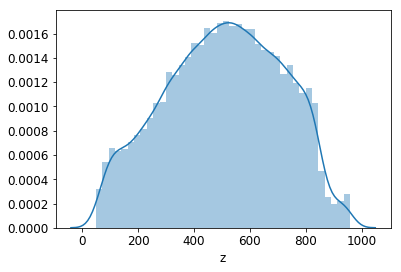

In [81]:
#depths distribution
df_depths = pd.read_csv('./depths.csv')
sns.distplot(df_depths['z']);

In [74]:
#loading samples
file_imgs = os.listdir(path='./train/images/')
file_masks = os.listdir(path='./train/masks/')
train_masks = pd.read_csv('./train.csv')
print('Images found: {0}\nCorresponding masks: {1}'.format(len(file_imgs), len(file_masks)))

Images found: 6
Corresponding masks: 6


In [80]:
## Defining a function since there's sample without valid RLE.
def choose_sample(data=train_masks):
    ## Choosing a random image from train dataset:
    sample = random.choice(range(len(data)))

    ## Parsing the sample information:
    sample_id = data['id'][sample]
    sample_depth = df_depths[df_depths['id'] == sample_id]['z'].values[0]
    sample_RLEstring = data['rle_mask'][sample]
    try: 
        sample_RLE = rleToMask(sample_RLEstring, 101,101)
    except: 
        sample_RLE = np.zeros((101,101))
    file_name = sample_id + '.png'
    sample_img = basic_readImg('train/images/',file_name)
    sample_mask = basic_readImg('train/masks/',file_name)
    
    fig1, axes = plt.subplots(1,3, figsize=(10,4))
    axes[0].imshow(sample_img)
    axes[0].set_xlabel('Subsurface image')
    axes[1].imshow(sample_mask)
    axes[1].set_xlabel('Provided mask')
    axes[2].imshow(sample_RLE)
    axes[2].set_xlabel('Decoded RLE mask')
    fig1.suptitle('Image ID = {0}\nDepth = {1} ft.'.format(sample_id, sample_depth));
    return

In [76]:
## Defining basic functions

def basic_readImg(directory, filename):
    '''Reading an RGB image through the scipy library. Provides an array.
    Sintaxe: basic_readImg(directory, filename).'''
    sample = scipyImg.imread(directory + filename, mode='RGB')
    if sample.shape[2] != 3:
        return 'The input must be an RGB image.'
    return sample

def basic_showImg(img, size=4):
    ''' Displays the image at the chosen size. The image (img) should be read through basic_readImg().
    Sintaxe: basic_showImg(img, size=4).'''
    plt.figure(figsize=(size,size))
    plt.imshow(img)
    plt.show()
    
def basic_writeImg(directory, filename, img):
    misc.imsave(directory+filename, img)

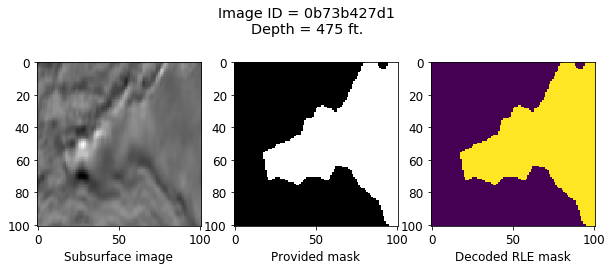

In [83]:
#sample image - mask and decoded RLE
choose_sample()

# Model

In [3]:
# Set some parameters
im_width = 224
im_height = 224
border = 5
im_chan = 3 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth
path_train = './train/'
path_test = './test/'
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test))[2]

In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (224, 224, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (224, 224, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 



Done!


In [5]:
# Define IoU metric
# This metric is used from Kaggle to evaluate the submission
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [6]:
""" Utility functions for segmentation models """
from functools import wraps

def get_layer_number(model, layer_name):
    """
    Help find layer in Keras model by name
    Args:
        model: Keras `Model`
        layer_name: str, name of layer

    Returns:
        index of layer

    Raises:
        ValueError: if model does not contains layer with such name
    """
    for i, l in enumerate(model.layers):
        if l.name == layer_name:
            return i
    raise ValueError('No layer with name {} in  model {}.'.format(layer_name, model.name))


def extract_outputs(model, layers, include_top=False):
    """
    Help extract intermediate layer outputs from model
    Args:
        model: Keras `Model`
        layer: list of integers/str, list of layers indexes or names to extract output
        include_top: bool, include final model layer output

    Returns:
        list of tensors (outputs)
    """
    layers_indexes = ([get_layer_number(model, l) if isinstance(l, str) else l
                      for l in layers])
    outputs = [model.layers[i].output for i in layers_indexes]

    if include_top:
        outputs.insert(0, model.output)

    return outputs

def reverse(l):
    """Reverse list"""
    return list(reversed(l))

# decorator for models aliases, to add doc string
def add_docstring(doc_string=None):
    def decorator(fn):
        if fn.__doc__:
            fn.__doc__ += doc_string
        else:
            fn.__doc__ = doc_string

        @wraps(fn)
        def wrapper(*args, **kwargs):
            return fn(*args, **kwargs)
        return wrapper
    return decorator

In [7]:
#import the model
from segmentation_models.unet import models

model = models.UInceptionV3()

In [8]:
#displays model summary
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [10]:
#Runs the model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer])


Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 317s 88ms/step - loss: 0.4362 - mean_iou: 0.4299 - val_loss: 0.4592 - val_mean_iou: 0.4759

Epoch 00001: val_loss improved from inf to 0.45920, saving model to model-tgs-salt-1.h5
Epoch 2/30
3600/3600 [==============================] - 243s 68ms/step - loss: 0.3599 - mean_iou: 0.4977 - val_loss: 0.4078 - val_mean_iou: 0.5156

Epoch 00002: val_loss improved from 0.45920 to 0.40777, saving model to model-tgs-salt-1.h5
Epoch 3/30
3600/3600 [==============================] - 243s 68ms/step - loss: 0.3262 - mean_iou: 0.5281 - val_loss: 0.2823 - val_mean_iou: 0.5469

Epoch 00003: val_loss improved from 0.40777 to 0.28230, saving model to model-tgs-salt-1.h5
Epoch 4/30
3600/3600 [==============================] - 243s 68ms/step - loss: 0.2973 - mean_iou: 0.5625 - val_loss: 0.3419 - val_mean_iou: 0.5724

Epoch 00004: val_loss did not improve from 0.28230
Epoch 5/30
3600/3600 [================

In [15]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (224, 224, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 



Done!


In [16]:
# Predict on train, val and test
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - 203s 11ms/step


In [17]:
#predction for test
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [19]:
# RLE mask
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

In [20]:
#Prepare for submission
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

# Free form visualization

In [6]:
#rle decode function
def rle_decode(rle_mask):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(101*101, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(101,101)

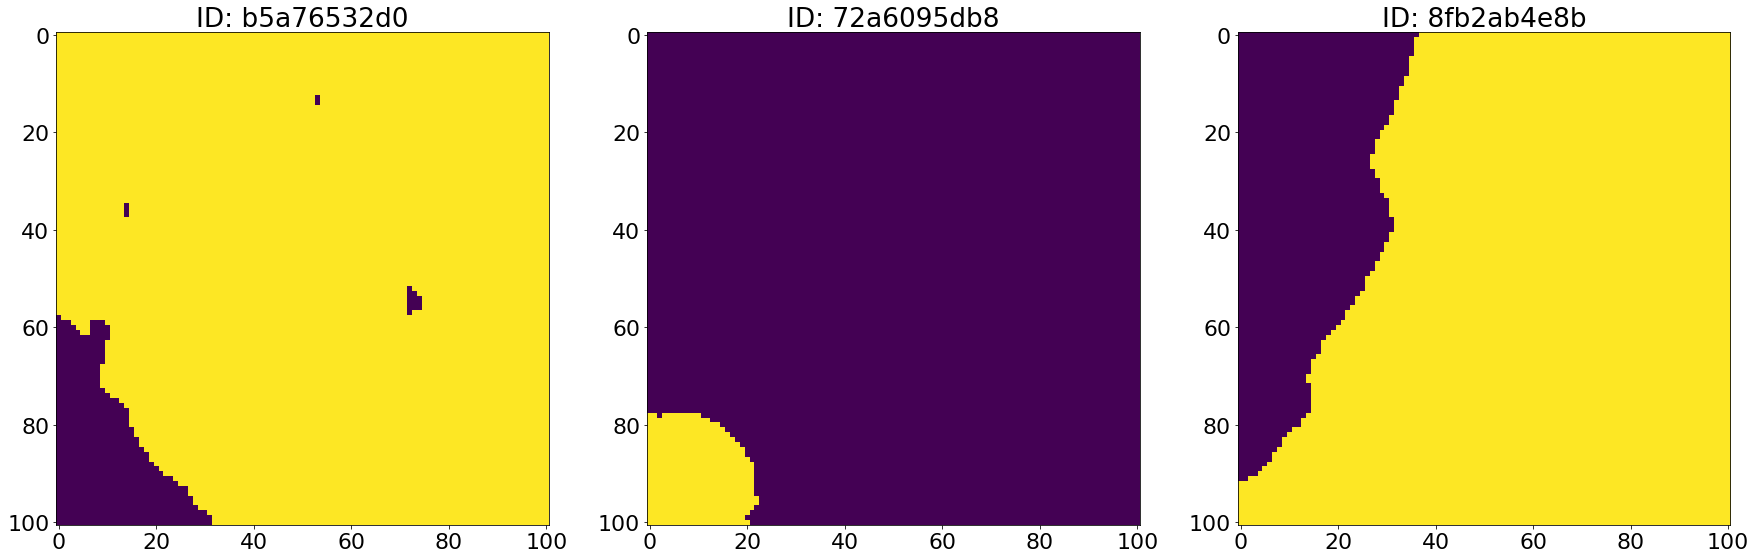

In [18]:
#showing some predicted output masks
df = pd.read_csv('submission.csv')
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])
        plt.subplot(1,3,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'id'])
        j = j + 1
        if j>2:
            break
    i = i + 1